In [7]:
from math import sqrt, exp, log
from datetime import timedelta as _timedelta, datetime as _datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [8,4]

# Generate Data

In [8]:
FILENAME = lambda sig, mu: f"RANPTH-{int(sig*10000):05d}-{int(mu*10000):04d}"
FILENAME(sig=0.2, mu=0)

'RANPTH-02000-0000'

In [9]:
FILENAME = None    # comment out to generate paths

## Code

### Data retrieval code

In [11]:
def dfread(fn):
    """reads dataframe from file and asserts format"""
    
    if fn[-7:] == ".pickle":
        df = pd.read_pickle(fn)
    else:
        df = pd.read_csv(fn)
    assert df.columns[0] == "time"
    assert df.columns[1] == "datetime"
    return df
    
def pdread(fn, datacol=None, indexcol=None):
    """
    reads a dataframe and returns a single column with index
    
    :fn:        the (full) filename
    :datacol:   name or index of the data col; None returns frame
    :indexcol:  name of the index col (default: "datetime")
    :returns:   pandas series
    """
    if indexcol is None: indexcol = "datetime"

    df = dfread(fn)
    df = df.set_index(indexcol)
    if datacol is None:
        return df.iloc[:, 1:]
    elif isinstance(datacol, str):
        return df[datacol]
    elif isinstance(datacol, int):
        return df.iloc[:, datacol+1]
    else:
        raise ValueError("datacol must be None, str or int", datacol)

def pdcols(fn):
    """
    reads a dataframe and returns a single column with index
    
    :fn:        the (full) filename
    :returns:   the column names (excluding the first two)
    """
    return dfread(fn).columns[2:]

def pathtime(path):
    """returns the time (in years) covered by the series `path`"""
    (path.index[-1]-path.index[0])/pd.Timedelta(days=1)/365.25

### Data generation code

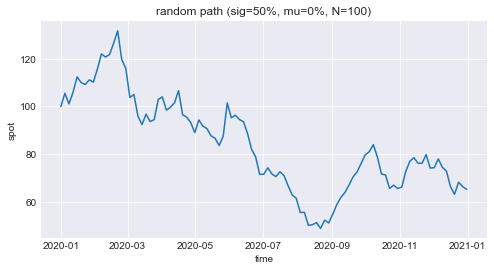

In [10]:
class PathGenerator():
    """
    generate random lognormal paths
    
    :mu:       drift parameter; eg 0.05 = 5%
    :sig:      volatility parameter; eg 0.2 = 20%
    :s0:       spot value at time zero
    :time:     time period (in years)
    :N:        number of steps (excluding t=0)
    """
    
    DEFAULTS = {
        "mu": 0,
        "sig": 0.5,
        "s0": 100,
        "time": 1,
        "N": 100,
        "startdt": (2020, 1, 1),
        "numpaths": 100,
        "colname": "p{i:04d}",
    }
    
    def __init__(self, mu=None, sig=None, s0=None, time=None, N=None, startdt=None):
        
        if mu is None: 
            mu = self.DEFAULTS["mu"]
        if sig is None: 
            sig = self.DEFAULTS["sig"]
        if s0 is None: 
            s0 = self.DEFAULTS["s0"]        
        if time is None: 
            time = self.DEFAULTS["time"] 
        if N is None: 
            N = self.DEFAULTS["N"]  
        if startdt is None: 
            startdt = self.DEFAULTS["startdt"]  
            
        self.mu = mu
        self.sig =sig
        self.s0 = s0
        self.time = time
        self.N = N
        self.startdt = startdt
        
        self.dt = time/N
        self.dt_td = _timedelta(days=self.dt*365.25)
        self.mudt = self.mu*self.dt
        self.halfsig2dt = 0.5*self.sig*self.sig*self.dt
        self.volsqrtdt = self.sig*sqrt(self.dt)
        self.times = np.array([i*self.dt for i in range(self.N+1)])
        self.datetimes = self._datetime_r(self.startdt)
            

    def path(self, plot=False):
        """
        generates a new random path
        
        :plot:     if True, plot the path
        """
        increments = np.random.default_rng().lognormal(
                        mean=        self.mudt - self.halfsig2dt, 
                        sigma=       self.volsqrtdt, 
                        size=        self.N)
        
        path = np.cumprod(np.insert(increments, 0, self.s0))
        if plot:
            self._plot(path)
        return path
    
    def _plot(self, path=None, datetimes=None):
        """
        plots the path with maplotlib
        """
        if path is None: path = self.path()
        if datetimes is None: datetimes = self.datetimes
        
        plt.title(f"random path (sig={self.sig*100:.0f}%, mu={self.mu*100:.0f}%, N={self.N})")
        plt.xlabel("time")
        plt.ylabel("spot")
        plt.plot(datetimes, path)
        plt.grid()
    
    def _datetime_r(self, startdt=None):
        """
        generates a datetime range
        
        :startdt:    either a datetime object, or tuple (day, month, year)
        """
        if startdt is None: startdt = self.DEFAULTS["startdt"]
        if not isinstance(startdt, _datetime):
            if not len(startdt) == 3:
                raise ValueError("startdate must be a tuple of lenght 3", startdt)
            startdt = _datetime(*startdt)
        return np.array([startdt+i*self.dt_td for i in range(self.N+1)])
    
    @staticmethod
    def vec2ar(paths):
        """concatenates list of vectors into a single numpy array"""
        return np.concatenate([p.reshape(-1,1) for p in paths], axis=1)
    
    def pathdf(self, numpaths=None, colname=None):
        """
        generate a pandas dataframe with newly generated paths
        
        :numpaths:    number of paths to generate
        :colname:     column name (format string; {i} is the path index)
        """
        
        if numpaths is None: numpaths = self.DEFAULTS["numpaths"]
        if colname is None: colname = self.DEFAULTS["colname"]
        
        paths = [self.path() for _ in range(numpaths)]
        df0 = pd.DataFrame(data=self.vec2ar([self.times, self.datetimes]), columns=["time", "datetime"])
        df1 = pd.DataFrame(data=self.vec2ar(paths), columns=[colname.format(i=i) for i in range(len(paths))])
        df = pd.concat([df0, df1], axis=1)
        return df
    
    def __call__(self):
        """
        alias for path
        """
        return self.path()
    
path = PathGenerator().path(plot=True)

## Data generation

In [12]:
if not FILENAME is None:
    print("Generating paths")
    for sig in (0.05, 0.1, 0.2, 0.5, 0.75, 1):
        df = PathGenerator(sig=sig).pathdf(1000)
        df.to_csv(FILENAME(sig=sig, mu=0)+".csv.gz", index=False, compression="gzip")
        #df.to_csv(FILENAME(sig=sig, mu=0)+".csv", index=False)
        df.to_pickle(FILENAME(sig=sig, mu=0)+".pickle")
else:
    print("Not generating paths")

Not generating paths


In [13]:
!ls *.pickle

RANPTH-00500-0000.pickle RANPTH-02000-0000.pickle RANPTH-07500-0000.pickle
RANPTH-01000-0000.pickle RANPTH-05000-0000.pickle RANPTH-10000-0000.pickle


In [14]:
!ls *.csv.gz

RANPTH-00500-0000.csv.gz RANPTH-02000-0000.csv.gz RANPTH-07500-0000.csv.gz
RANPTH-01000-0000.csv.gz RANPTH-05000-0000.csv.gz RANPTH-10000-0000.csv.gz


In [15]:
!ls *.csv

zsh:1: no matches found: *.csv


## Data retrieval examples

In [16]:
fn = "RANPTH-05000-0000.pickle"

In [17]:
#pd.read_csv(fn)

In [18]:
#pdread(fn)

In [19]:
pdcols(fn)

Index(['p0000', 'p0001', 'p0002', 'p0003', 'p0004', 'p0005', 'p0006', 'p0007',
       'p0008', 'p0009',
       ...
       'p0990', 'p0991', 'p0992', 'p0993', 'p0994', 'p0995', 'p0996', 'p0997',
       'p0998', 'p0999'],
      dtype='object', length=1000)

In [20]:
pdread(fn, "p0000")

datetime
2020-01-01 00:00:00    100.000000
2020-01-04 15:39:36     99.108220
2020-01-08 07:19:12     99.597403
2020-01-11 22:58:48     96.585946
2020-01-15 14:38:24     98.135103
                          ...    
2020-12-16 15:21:36     83.516513
2020-12-20 07:01:12     92.398691
2020-12-23 22:40:48     92.676844
2020-12-27 14:20:24     92.100810
2020-12-31 06:00:00     86.559263
Name: p0000, Length: 101, dtype: float64

In [21]:
ser = pdread(fn, 0)
ser

datetime
2020-01-01 00:00:00    100.000000
2020-01-04 15:39:36     99.108220
2020-01-08 07:19:12     99.597403
2020-01-11 22:58:48     96.585946
2020-01-15 14:38:24     98.135103
                          ...    
2020-12-16 15:21:36     83.516513
2020-12-20 07:01:12     92.398691
2020-12-23 22:40:48     92.676844
2020-12-27 14:20:24     92.100810
2020-12-31 06:00:00     86.559263
Name: p0000, Length: 101, dtype: float64

In [25]:
ser.index[0]

Timestamp('2020-01-01 00:00:00')

In [24]:
pd.Timedelta(days=1)

Timedelta('1 days 00:00:00')

In [26]:
ser.index[-1]-ser.index[0]

Timedelta('365 days 06:00:00')

In [27]:
(ser.index[-1]-ser.index[0])/pd.Timedelta(days=1)

365.25